In [2]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [2]:
def countWeight(pauli_string):
    """
    Counts the number of non-identity Paulis in a given string.
    """
    
    return sum(1 for p in pauli_string if p != 'I')

def generateSample(weight, length):
    """
    Generates a Pauli string of length `length` with a given weight `weight`.
    """
    
    # Initialize all identities
    pauli_string = ['I'] * length
    
    # Randomly choose k distinct positions
    positions = np.random.choice(length, size=weight, replace=False)
    
    # Assign random Paulis (X, Y, Z) to the chosen positions
    paulis = ['X', 'Y', 'Z']
    for pos in positions:
        pauli_string[pos] = np.random.choice(paulis)
    
    return ''.join(pauli_string)

def commutes(pauli1, pauli2):
    """
    Check if two Pauli strings commute.
    """
    anti_commute_count = 0
    for p1, p2 in zip(pauli1, pauli2):
        if p1 == 'I' or p2 == 'I':
            continue  
        if p1 != p2:
            anti_commute_count += 1
    
    # If the number of anti-commuting pairs is even, they commute.
    return anti_commute_count % 2 == 0

def pauliProduct(pauli1, pauli2):
    """
    Computes the product of two Pauli strings.
    """
    
    result = []
    for p1, p2 in zip(pauli1, pauli2):
        if p1 == 'I':
            result.append(p2)
        elif p2 == 'I':
            result.append(p1)
        elif p1 == p2:
            result.append('I')
        else:
            # X*Y = Z, Y*Z = X, Z*X = Y
            if (p1 == 'X' and p2 == 'Y') or (p1 == 'Y' and p2 == 'X'):
                result.append('Z')
            elif (p1 == 'Y' and p2 == 'Z') or (p1 == 'Z' and p2 == 'Y'):
                result.append('X')
            elif (p1 == 'Z' and p2 == 'X') or (p1 == 'X' and p2 == 'Z'):
                result.append('Y')
    
    return ''.join(result)

def newWeight(pauli1, pauli2):
    """
    Calculates new weight following the branching rule:"
    """
    if not commutes(pauli1, pauli2):
        return max(countWeight(pauli1), countWeight(pauli2))
    else:
        return countWeight(pauliProduct(pauli1, pauli2))


In [6]:
def countWeight(pauli_array):  
    count = 0
    for p in pauli_array:
        if p != 0:  
            count += 1
    return count

def generateSample(weight, length):
    # Initialize Pauli string as all identities (0 = I)
    pauli_array = np.zeros(length, dtype=np.int8)
    
    # Create an array of indices and shuffle
    indices = np.arange(length)
    
    # Fisher-Yates shuffle for first `weight` indices
    for i in range(weight):
        j = np.random.randint(i, length)
        indices[i], indices[j] = indices[j], indices[i]
    
    # Fill first `weight` indices with random Pauli (1 = X, 2 = Y, 3 = Z)
    for i in range(weight):
        pauli_array[indices[i]] = np.random.randint(1, 4)

    return pauli_array

def commutes(pauli1, pauli2):
    anti_commute = 0
    for p1, p2 in zip(pauli1, pauli2):
        if p1 == 0 or p2 == 0:
            continue
        if p1 != p2:
            anti_commute += 1
    return anti_commute % 2 == 0

PRODUCT_TABLE = np.array([
    [0, 1, 2, 3],
    [1, 0, 3, 2],
    [2, 3, 0, 1],
    [3, 2, 1, 0]
], dtype=np.int8)

def pauliProduct(pauli1, pauli2):
    result = np.zeros(len(pauli1), dtype=np.int8)
    for i in range(len(pauli1)):
        result[i] = PRODUCT_TABLE[pauli1[i], pauli2[i]]
    return result

def newWeight(p1, p2):
    if not commutes(p1, p2):
        return max(countWeight(p1), countWeight(p2))
    else:
        product = pauliProduct(p1, p2)
        return countWeight(product)

In [ ]:


def single_trial(args):
    w, l = args
    pauli1 = generateSample(w, l)
    weightQ = l - 2
    pauli2 = generateSample(weightQ, l)
    nWeight = newWeight(pauli1, pauli2)
    if nWeight < weightQ:
        return (-1)
    elif nWeight > weightQ:
        return 1
    else:
        return 


In [19]:
def createPauliArray(size, paulis, indices):
    """
    Creates an integer-encoded Pauli array of given size with given paulis at specified indices.
    paulis: list of int (1=X, 2=Y, 3=Z)
    indices: list of int
    """
    pauli_array = np.zeros(size, dtype=np.int8)
    for i in range(len(paulis)):
        pauli_array[indices[i]] = paulis[i]
    return pauli_array


def sampleHeisenberg(length):
    """
    Sample two-site Heisenberg term: X_i X_{i+1}, Y_i Y_{i+1}, or Z_i Z_{i+1}
    """
    pauli_type = np.random.randint(1, 4)  # 1=X, 2=Y, 3=Z
    i = np.random.randint(0, length - 1)
    return createPauliArray(length, [pauli_type, pauli_type], [i, i + 1])

def sampleTFIM(length):
    """
    Sample from TFIM: with 50% chance returns X_i or Z_i Z_{i+1}
    """
    if np.random.rand() < 0.5:
        i = np.random.randint(0, length)
        return createPauliArray(length, [1], [i])  # 1 = X
    else:
        i = np.random.randint(0, length - 1)
        return createPauliArray(length, [3, 3], [i, i + 1])  # 3 = Z

def PplusHeise(n,w):
    prob = (n-w)*(n-w-1)/(n*(n-1))
    return prob
def PminusHeise(n,w):
    prob = w*(w-1)/(9*n*(n-1))
    return prob
def PeqHeise(n,w):
    prob = w*(2*n-10/9*w-8/9)/(n*(n-1))
    return prob

def PminusTFIM(n,w):
    prob = w*(w+3*n-1)/(9*n*(2*n-1))
    return prob
def PplusTFIM(n,w):
    prob = (n-w)*(2*n-w-1)/(n*(2*n-1))
    return prob
def PeqTFIM(n,w):
    prob = w*(8*n-10/3*w-8/3)/(3*n*(2*n-1))
    return prob

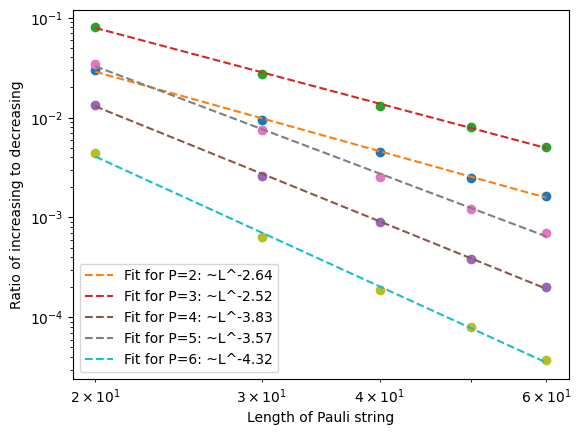

In [47]:
samples = 200000
length = [20, 30, 40, 50, 60]

weightP = [2, 3, 4, 5, 6]
plt.figure()
for k in range(len(weightP)):
    probPlus = np.zeros(len(length))
    probMinus = np.zeros(len(length))
    for j in range(len(length)):
        for i in range(samples):
            weightQ = 7
            pauli1 = generateSample(weightQ, length[j])
            pauli2 = generateSample(weightP[k], length[j]) 
            nWeight = newWeight(pauli1, pauli2)
            if nWeight > weightQ:
                probPlus[j] += 1 
            elif nWeight < weightQ:
                probMinus[j] += 1

    probPlus /= samples
    probMinus /= samples
    R = probMinus / probPlus
    logL = np.log(length)
    logR = np.log(R)
    coeffs = np.polyfit(logL, logR, 1)
    plt.plot(length, R, 'o')
    fitted_R = np.exp(coeffs[1]) * np.array(length)**coeffs[0]
    plt.plot(length, fitted_R, '--', label=f'Fit for P={weightP[k]}: ~L^{coeffs[0]:.2f}')
plt.xlabel('Length of Pauli string')
plt.ylabel('Ratio of increasing to decreasing')
plt.xscale('log')
plt.yscale('log')
plt.legend()

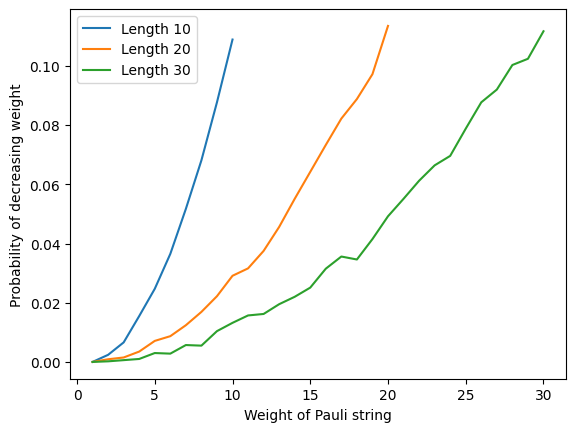

In [8]:
samples = 10000
length = [10, 20, 30]
plt.figure()
for k in range(len(length)):
    weight = np.arange(1, length[k]+1)
    prob = np.zeros(len(weight))
    for j in range(len(weight)):
        for i in range(samples):
            pauli1 = generateSample(weight[j],length[k])
            pauli2 = generateSample(2, length[k]) # We only consider two weighted Paulis
            nWeight = newWeight(pauli1, pauli2)
            if nWeight < weight[j]:
                prob[j] += 1 

    prob = prob / samples
    plt.plot(weight, prob, label=f'Length {length[k]}')
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of decreasing weight')
plt.legend()

In [16]:
def analyticFormula(length, weight):
    """
    Analytic formula for the probability of decreasing weight.
    """
    
    return 1/9 * weight*(weight-1)/(length*(length-1))

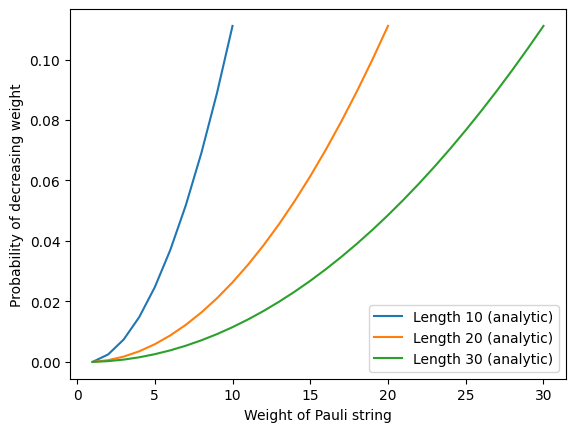

In [17]:
length  = [10, 20, 30]
plt.figure()
for i in range(len(length)):
    weight = np.arange(1, length[i]+1)
    prob = analyticFormula(length[i], weight)
    plt.plot(weight, prob, label=f'Length {length[i]} (analytic)')
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of decreasing weight')
plt.legend()
plt.show()

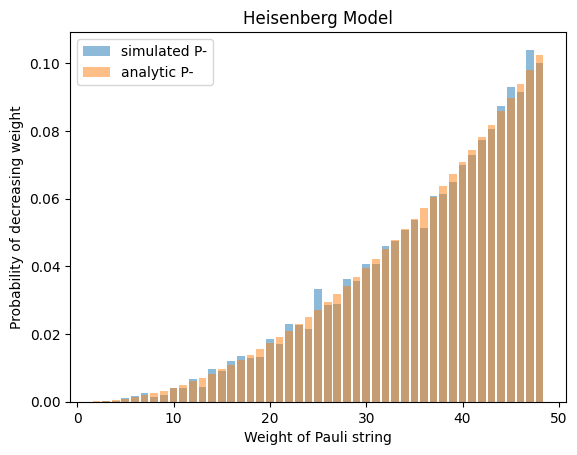

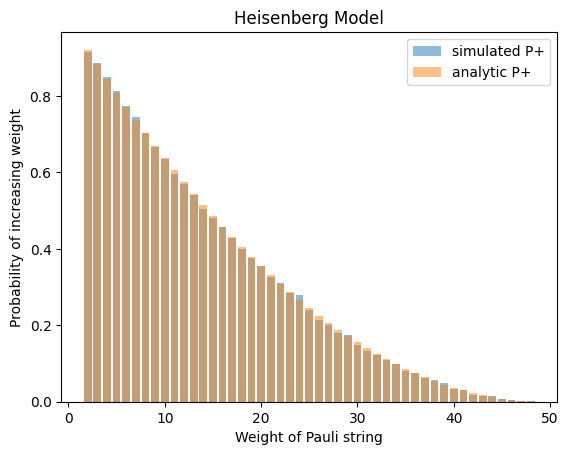

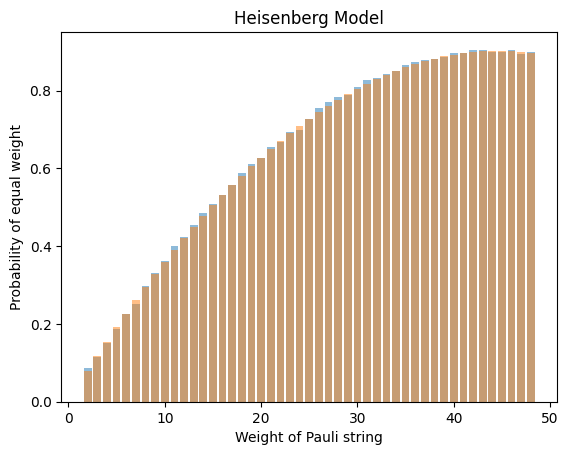

In [20]:
np.random.seed(0)
samples = 5000
length = 50

weight = np.arange(2, 49)
probDecrease = np.zeros(len(weight))
probIncrease = np.zeros(len(weight))
probEqual = np.zeros(len(weight))

for w in range(len(weight)):
    for i in range(samples):
        pauli1 = generateSample(weight[w], length)
        pauli2 = sampleHeisenberg(length)
        nWeight = newWeight(pauli1, pauli2)
        if nWeight < weight[w]:
            probDecrease[w] += 1 
        elif nWeight > weight[w]:
            probIncrease[w] += 1
        else:
            probEqual[w] += 1


    probEqual[w] = probEqual[w] / samples
    probIncrease[w] = probIncrease[w] / samples
    probDecrease[w] = probDecrease[w] / samples

PplusExact = PplusHeise(length, weight)
PminusExact = PminusHeise(length, weight)
PeqExact = PeqHeise(length, weight)

plt.figure()
plt.title('Heisenberg Model')
plt.bar(weight, probDecrease, alpha=0.5, label='simulated P-')
plt.bar(weight, PminusExact, alpha=0.5, label='analytic P-')
plt.legend()
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of decreasing weight')
plt.show()

plt.figure()
plt.title('Heisenberg Model')
plt.bar(weight, probIncrease, alpha=0.5, label='simulated P+')
plt.bar(weight, PplusExact, alpha=0.5, label='analytic P+')
plt.legend()
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of increasing weight')
plt.show()

plt.figure()
plt.title('Heisenberg Model')
plt.bar(weight, probEqual, alpha=0.5, label='simulated P=')
plt.bar(weight, PeqExact, alpha=0.5, label='analytic P=')
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of equal weight')
plt.show()

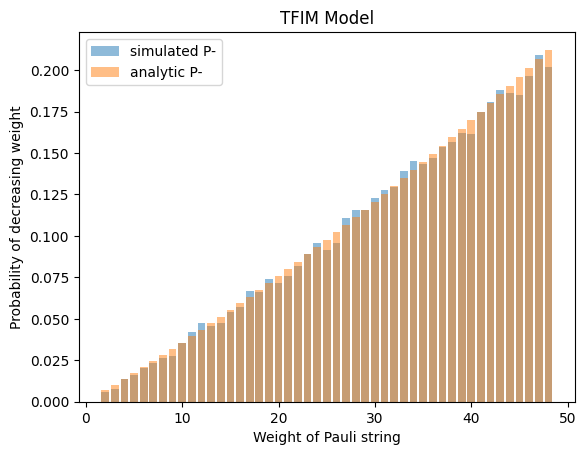

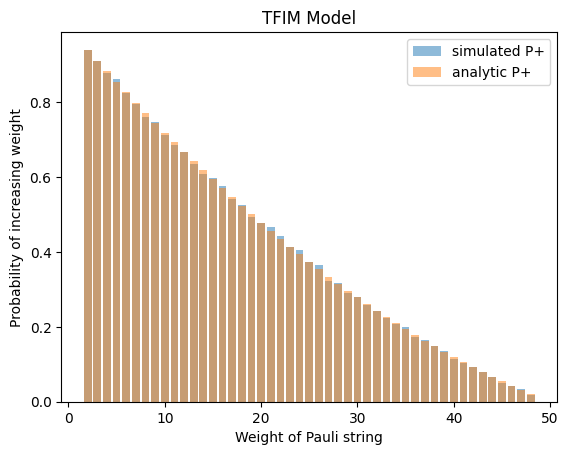

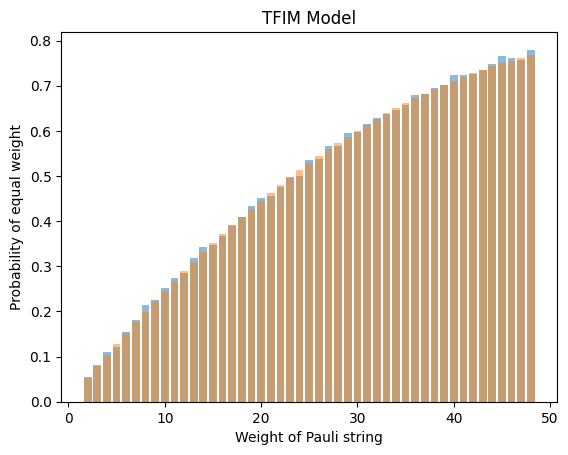

In [21]:
np.random.seed(0)
samples = 5000
length = 50

weight = np.arange(2, 49)
probDecrease = np.zeros(len(weight))
probIncrease = np.zeros(len(weight))
probEqual = np.zeros(len(weight))

for w in range(len(weight)):
    for i in range(samples):
        pauli1 = generateSample(weight[w], length)
        pauli2 = sampleTFIM(length)
        nWeight = newWeight(pauli1, pauli2)
        if nWeight < weight[w]:
            probDecrease[w] += 1 
        elif nWeight > weight[w]:
            probIncrease[w] += 1
        else:
            probEqual[w] += 1


    probEqual[w] = probEqual[w] / samples
    probIncrease[w] = probIncrease[w] / samples
    probDecrease[w] = probDecrease[w] / samples

PplusExact = PplusTFIM(length, weight)
PminusExact = PminusTFIM(length, weight)
PeqExact = PeqTFIM(length, weight)

plt.figure()
plt.title('TFIM Model')
plt.bar(weight, probDecrease, alpha=0.5, label='simulated P-')
plt.bar(weight, PminusExact, alpha=0.5, label='analytic P-')
plt.legend()
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of decreasing weight')
plt.show()

plt.figure()
plt.title('TFIM Model')
plt.bar(weight, probIncrease, alpha=0.5, label='simulated P+')
plt.bar(weight, PplusExact, alpha=0.5, label='analytic P+')
plt.legend()
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of increasing weight')
plt.show()

plt.figure()
plt.title('TFIM Model')
plt.bar(weight, probEqual, alpha=0.5, label='simulated P=')
plt.bar(weight, PeqExact, alpha=0.5, label='analytic P=')
plt.xlabel('Weight of Pauli string')
plt.ylabel('Probability of equal weight')
plt.show()